### Open Shots Models

Note: Several cells in this notebook will take a very long time to run. The hyper-parameter tuning for the random forest and training for the neural network are very lengthy.

In this notebook, we try to determine the true effect of open shots on making field goals. As noted in the EDA, it's difficult to determine this relationship without controlling for other potential predictors, such as shot type and distance. Accordingly, we trained a regression so we can account for other features and get a true estimate for open shot effects. We also trained two additional models, a random forest and neural network, to compare predictive accuracy against the base regression.

#### Packages and Data

In [29]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [8]:
# Load open shots dataset
open_shots_df = pd.read_csv('../data/clean/open_shot.csv')

#### Feature Engineering

In [9]:
# Convert game clock to seconds
open_shots_df['game_clock_sec'] = open_shots_df['game_clock'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

# When shot clock is null, set it to the game clock
open_shots_df['shot_clock'] = open_shots_df['shot_clock'].fillna(open_shots_df['game_clock_sec'])

# Create dummy variable for home, when location is 'H'
open_shots_df['home'] = open_shots_df['location'].apply(lambda x: 1 if x == 'H' else 0)

# Dummy variable if shot clock is less than 5 seconds
open_shots_df['shot_clock_5'] = open_shots_df['shot_clock'].apply(lambda x: 1 if x < 5 else 0)

# Dummy variable if shot clock is less than 2 seconds
open_shots_df['shot_clock_2'] = open_shots_df['shot_clock'].apply(lambda x: 1 if x < 2 else 0)

# Dummy variable if shot is a three
open_shots_df['three'] = open_shots_df['pts_type'].apply(lambda x: 1 if x == 3 else 0)

# Dummy variable for long two's, when pts_type is 2 and shot_distance is greater than 10
open_shots_df['long_two'] = open_shots_df.apply(lambda x: 1 if x['pts_type'] == 2 and x['shot_dist'] > 10 else 0, axis=1)

# Encode shot_result, 1 if 'made', 0 if 'missed'
open_shots_df['shot_result'] = open_shots_df['shot_result'].apply(lambda x: 1 if x == 'made' else 0)

Here we do some basic feature engineering for the dataset, including converting the game clock from string format to seconds and fixing scenarios where the shot clock is 'off'. We also included several dummy variables, including whether the player is home, if at the end of the shot clock, and which shooting region they are in (three and long-two with close twos as the baseline).

#### Logistic Regression

In [10]:
# Split data into training and testing sets
X = sm.add_constant(
    open_shots_df[['game_clock_sec', 'shot_clock', 'shot_clock_5', 'shot_clock_2',
                   'period', 'touch_time', 'dribbles', 'shot_number', 'home', 
                   'shot_dist', 'three', 'long_two', 'defender_wingspan', 'open_shot']]
)
y = open_shots_df['shot_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Display the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.658309
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            shot_result   No. Observations:               102455
Model:                          Logit   Df Residuals:                   102440
Method:                           MLE   Df Model:                           14
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                 0.04384
Time:                        22:52:22   Log-Likelihood:                -67447.
converged:                       True   LL-Null:                       -70539.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.1054      0.141     14.883      0.000       1.828       2.383
game_clo

In [11]:
# Predicting the probabilities
y_pred_prob = result.predict(X_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6072850784727102


In [17]:
# Create confusion matrix
print(confusion_matrix(y_test, y_pred))

[[10436  3560]
 [ 6499  5119]]


In [18]:
# Create classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.75      0.67     13996
           1       0.59      0.44      0.50     11618

    accuracy                           0.61     25614
   macro avg       0.60      0.59      0.59     25614
weighted avg       0.60      0.61      0.60     25614



The first model we trained was a logistic regression, predicting whether a shot will go in based on features related to time in the game, shot location, the defender, and whether the shot was open. The output of the regression shows that open looks are statistically significant in increasing the likelihood of a shot going in. This is demonstrated by the very low p-value for the open_shot predictor, with a value that rounds to 0.000. This highlights that after controlling for other predictive features (such as shot distance), open looks are strongly correlated with making shots. 

Several other predictors in the regression demonstrated statistical significance as well. This includes variables such as whether a player was at home, the shot distance, defender wingspan, and game period, among others. Furthermore, we tested the model's performance on a test dataset, and the model correctly classified just under 61% of shots. Although this accuracy score isn't very high in a vacuum, it is fairly performant considering the high-level of randomness when shooting. Additionally, average field goal percentage is in the low 40's, meaning this model is much better than a random classifier. We will use the accuracy and precision/recall scores to compare the regression to more sophisticated models next.

#### Random Forest

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [25]:
# Make predictions on test data using the best model
y_pred_rf = best_model.predict(X_test)

# Calculating accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf}')

Accuracy: 0.6107206996173967


In [26]:
# Create confusion matrix
print(confusion_matrix(y_test, y_pred_rf))

[[11432  2564]
 [ 7407  4211]]


In [27]:
# Create classification report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.61      0.82      0.70     13996
           1       0.62      0.36      0.46     11618

    accuracy                           0.61     25614
   macro avg       0.61      0.59      0.58     25614
weighted avg       0.61      0.61      0.59     25614



In this section, we trained a random forest model with the same dataset to compare performance with the logistic regression. The random forest model slightly out-performs the regression in terms of accuracy, improving the score from 0.607 to 0.610. The random forest also shows similar performance in the context of f1-score as the regression model. For classifying missed shots, the random forest improves upon the f1-score of the reression from 0.67 to 0.70. For made shots, the f1-score decreased slightly from 0.50 to 0.46. The similar performance between these models suggests the added complexity of a random forest is not worth the minor increase in predictive accuracy. In a real-life setting, we would choose the logistic regression as we get a more comprehensive understanding of how all inputs translate to the predictions through the coefficients.

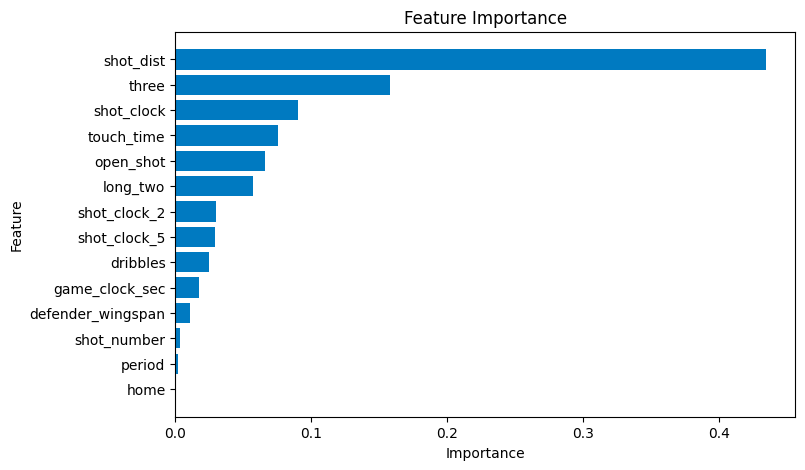

In [48]:
# Feature importance from the best model
feature_importance = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=True)

# Exclude 'const' from the dataframe
feature_importance_df = feature_importance_df[feature_importance_df['feature'] != 'const']

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='#007AC1')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

The random forest model enables us to produce this feature plot showing the relative importance of each feature in predicting whether the shot is made. By far the most important feature is shot distance, which makes intuitive sense. Being much further away from the basket makes it significantly less likely to make a shot. The next three most important features are whether the player is in the three region, the shot clock, and how long they had the ball. Coming in at number 5 is the open_shot dummy variable, which is one of the most predictive of all the features. This aligns well with the results of the regression, where having an open look is very informative for predicting mades shots. 

#### Neural Network

In [30]:
# Define a simple neural network for classification
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Set random seed for reproducibility
torch.manual_seed(42)

In [35]:
# Define hyperparameters
input_size = 15
hidden_size = 128
output_size = 1
learning_rate = 0.001
batch_size = 64
epochs = 50

In [36]:
# Converting to Tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [37]:
# Initialize model, loss function, and optimizer
model = SimpleClassifier(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
# Training loop for neural network
for epoch in range(epochs):
    loss_list = []
    for inputs, labels in train_loader:
        inputs = inputs.view(-1, input_size) 
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    if (epoch+1) % 5 == 0:
        print('----------------------------------------------')
        print(f'Epoch {epoch+1}/{epochs}, Loss: {np.mean(loss_list)}')

        model.eval()

        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                output_flatten = outputs.view(-1)
                predicted = (output_flatten > 0.5).float()
                total += labels.size(0)
                labels_flatten = labels.view(-1)
                correct += (predicted == labels_flatten).sum().item()

        accuracy = correct / total
        print(f'Test Accuracy: {accuracy}')


----------------------------------------------
Epoch 5/50, Loss: 0.6536904183273983
Test Accuracy: 0.6136487858202545
----------------------------------------------
Epoch 10/50, Loss: 0.6536957344585922
Test Accuracy: 0.6141563207620833
----------------------------------------------
Epoch 15/50, Loss: 0.6539630413725553
Test Accuracy: 0.613063168579683
----------------------------------------------
Epoch 20/50, Loss: 0.6535234818750437
Test Accuracy: 0.6126337159365972
----------------------------------------------
Epoch 25/50, Loss: 0.6535832002191228
Test Accuracy: 0.613063168579683
----------------------------------------------
Epoch 30/50, Loss: 0.653690670632631
Test Accuracy: 0.6147028968532834
----------------------------------------------
Epoch 35/50, Loss: 0.6534251800408444
Test Accuracy: 0.6125165924884829
----------------------------------------------
Epoch 40/50, Loss: 0.6533034981451207
Test Accuracy: 0.611540563754197
----------------------------------------------
Epoch 

The final model we trained was a neural network. Although this type of model is not typically suited for smaller, tabular datasets like the shot logs, we wanted to include it to compare models at varying complexity levels. While the regression is a very interpretable and simple model, the neural network is a black box with the ability to interact features on its own. Compared to the regression and random forest, the neural network also slightly improves on accuracy. After 50 training epochs, the neural network produced an accuracy score of 0.614 on the test dataset. In a similar fashion to the random forest, we don't believe this slight increase in accuracy is worth the loss of interpretability with the black box network. Accordingly, we would select the logistic regression if utilizing this in the real world.